# Symulacje

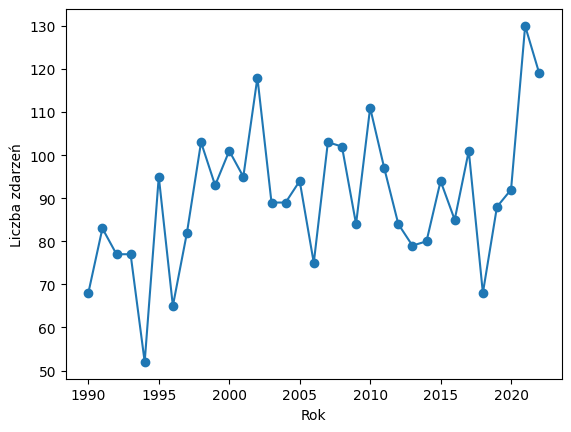

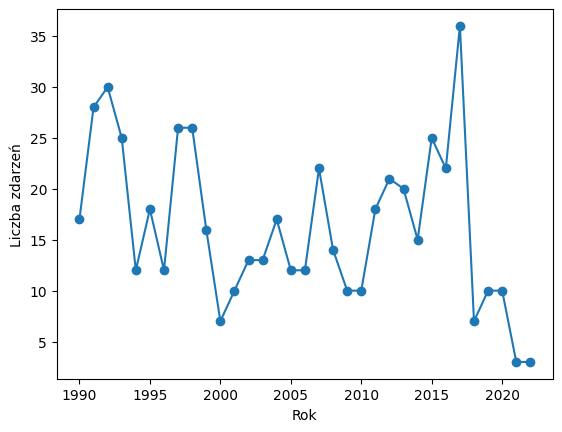

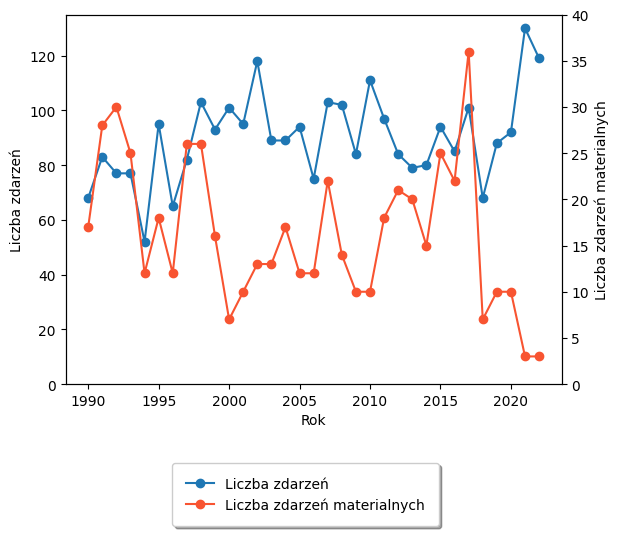

C:\Users\ndzadz001\AppData\Local\Temp\ipykernel_15124\2429601217.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


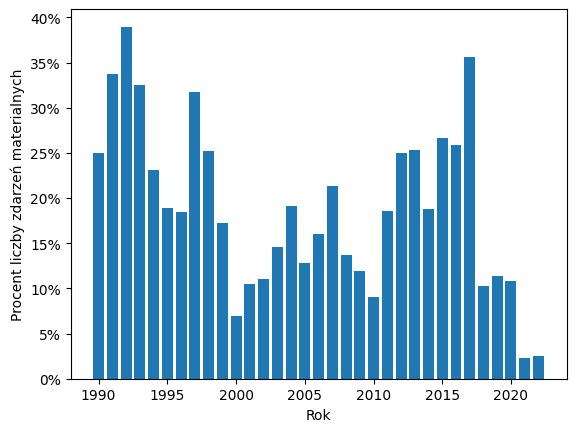

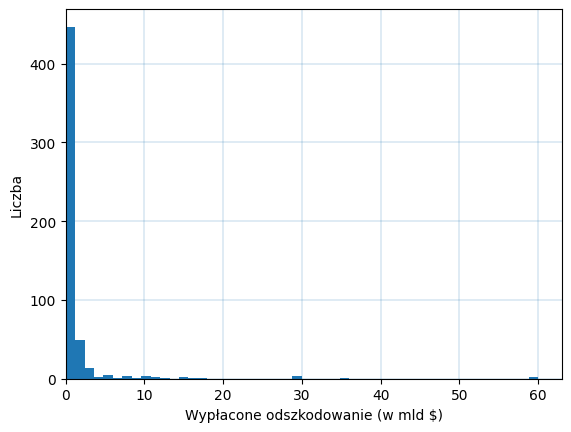

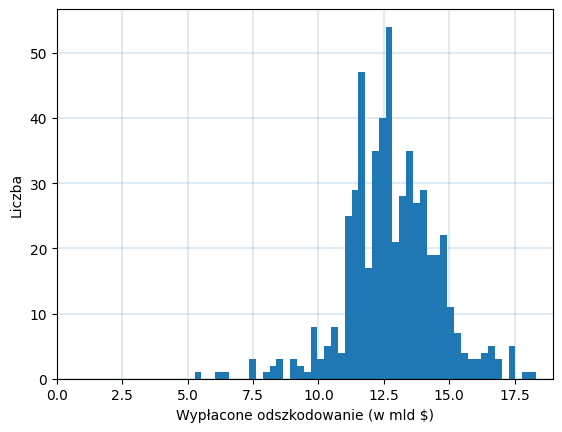

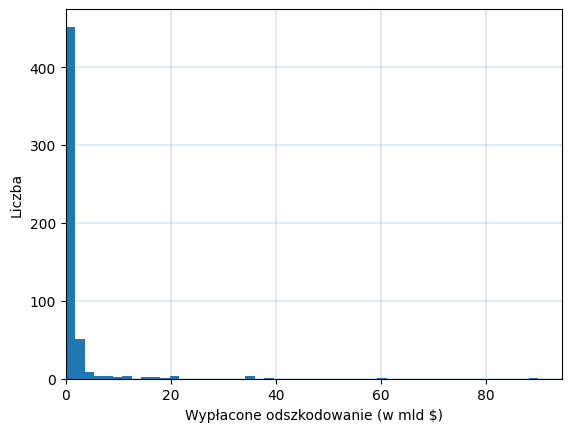

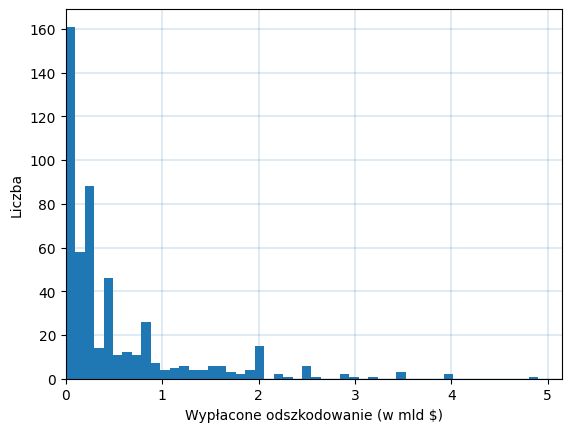

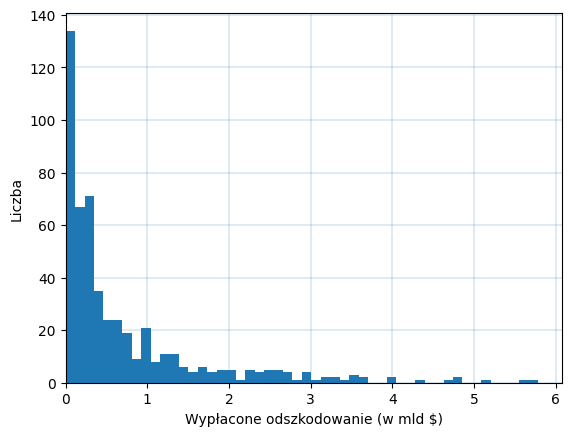

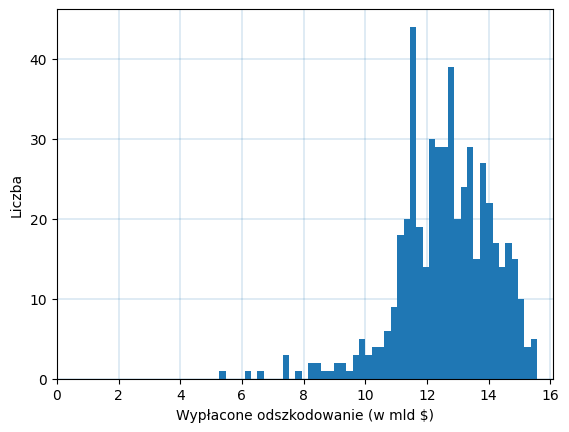

In [102]:
%run "C:\Users\ndzadz001\Documents\Mgr\Repo\mgr\DataPreparation.ipynb"
%run "C:\Users\ndzadz001\Documents\Mgr\Repo\mgr\Modelowanie_liczby_roszczen.ipynb"

In [5]:
#%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\DataPreparation.ipynb"
#%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_liczby_roszczen.ipynb"
#%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_wartosci_odszkodowan.ipynb"
#%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_wartosci_ryzyka.ipynb"

### Symulacja liczby roszczeń

Empiryczna liczba roszczeń ze zbioru danych

In [106]:
T = pd.DataFrame({'t':[1990 + t/365 for t in range((datetime.datetime(2022,12,31)-datetime.datetime(1990,1,1)).days)]})
N = pd.merge(T, data_wo[['t','Ind']], on='t', how='left').fillna(0).cumsum().assign(Year=np.floor(pd.merge(T, data_wo[['t','Ind']], on='t', how='left')['t']))
n = pd.merge(T, data_wo[['t','Ind']], on='t', how='left').fillna(0).assign(Year=np.floor(pd.merge(T, data_wo[['t','Ind']], on='t', how='left')['t'])).groupby('Year').sum()['Ind']

T_train = pd.DataFrame({'t':[1990 + t/365 for t in range((datetime.datetime(2013,1,6)-datetime.datetime(1990,1,1)).days)]})
n_train = n[n.index<=2012]
N_train = N[N['Year']<=2012] #N_train jest hard-kodowane w definicjach funkcji sum_of_squares_sin i sum_of_squares_exp

n_test = n[n.index>2012]
N_test = N[N['Year']>2012]

In [108]:
bnds = ((0, None), (0, None), (0, None)) # ograniczenia na wartości parametrów
params = [0, 0, 0] # Przyjmujemy początkowe wartości parametrów
minimize(nhpp_sin, params, bounds=bnds, method='L-BFGS-B')

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 83465240.61067948
        x: [ 1.018e-01  4.617e-05  1.693e-08]
      nit: 2
      jac: [-1.192e+04  3.622e+03 -1.341e+01]
     nfev: 28
     njev: 7
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [85]:
number_of_simulations = 1000

Sinusoidalna funkcja intensywności

In [265]:
bnds = ((0, None), (0, None), (0, None)) # ograniczenia na wartości parametrów
params = [0, 0, 0] # Przyjmujemy początkowe wartości parametrów
result_sin = minimize(nhpp_sin, params, bounds=bnds, method='Nelder-Mead')
n_sum = pd.Series(0, index=range(2013,2023))

MAE_sin = []
MSE_sin = []

for i in range (number_of_simulations):
    nhpp_pred = nhpp(sin_int_fun,result_sin.x,11)
    unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
    values = pd.DataFrame({'Year':2012+unique, 'n':counts})
    index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
    merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
    n_pred = pd.Series(merged_table['n'])
    MAE_sin.append(MAE(n_test, n_pred))
    MSE_sin.append(MSE(n_test, n_pred))

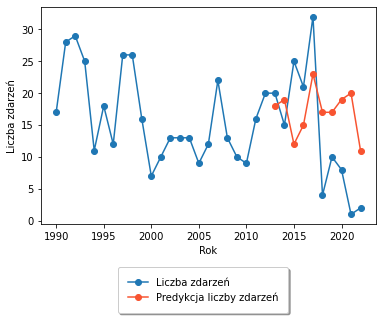

In [273]:
nhpp_pred = nhpp(sin_int_fun,result_sin.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred_sin = pd.Series(merged_table['n'])

plt.plot(n, linestyle= '-',marker='o')
plt.plot(n_pred_sin, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
plt.figlegend(['Liczba zdarzeń','Predykcja liczby zdarzeń'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\sin_number.pdf",bbox_inches='tight')
plt.show()

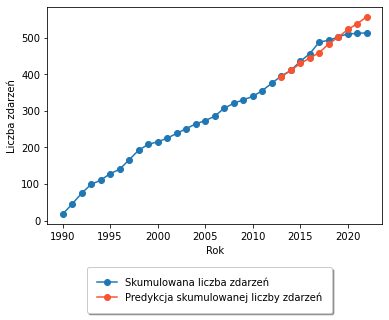

In [272]:
n_pred_sin_cum = n_pred_sin.cumsum()

plt.plot(N, linestyle= '-',marker='o')
plt.plot(N[2012]+n_pred_sin_cum, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
plt.figlegend(['Skumulowana liczba zdarzeń','Predykcja skumulowanej liczby zdarzeń'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\sin_cum_number.pdf",bbox_inches='tight')
plt.show()

Funkcja intensywności typu Power Law

In [377]:
N_train

0      17
1      45
2      74
3      99
4     110
5     128
6     140
7     166
8     192
9     208
10    215
11    225
12    238
13    251
14    264
15    273
16    285
17    307
18    320
19    330
20    339
21    355
22    375
Name: Dis No, dtype: int64

In [395]:
def nhpp_sin(lambda_func_params):
    t = len(N_train)-1
    return np.array((N_train-[lambda_func_params[0]*t-lambda_func_params[1]*np.cos(2*np.pi*(t-lambda_func_params[2]))+lambda_func_params[1]*np.cos(2*np.pi*lambda_func_params[2]) for t in range(1,len(N_train)+1)])**2)

In [394]:
nhpp_sin([17.29070302,1,2])

9684.58626271971

In [384]:
nhpp_sin([17.29070302,0,0])

9684.58626271971

In [389]:
bnds = ((0, None), (0, None), (0, None)) # ograniczenia na wartości parametrów
params = [0,0,0] # Przyjmujemy początkowe wartości parametrów
minimize(nhpp_sin, params, bounds=bnds, method='L-BFGS-B')

      fun: 9684.586262719708
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0001819,  0.       ,  0.       ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 20
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([17.29070302,  0.        ,  0.        ])

In [343]:
bnds = ((0, None), (0, 1)) # ograniczenia na wartości parametrów
params = [0, 0.5] # Przyjmujemy początkowe wartości parametrów
minimize(nhpp_power_law, params, bounds=bnds, method='L-BFGS-B')

      fun: 1034.2621798502475
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00084128, -0.05961738])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 14
     njev: 26
   status: 0
  success: True
        x: array([32.41850566,  0.77636404])

In [266]:
bnds = ((0, None), (0, 1)) # ograniczenia na wartości parametrów
params = [0, 0.5] # Przyjmujemy początkowe wartości parametrów
result_power_law = minimize(nhpp_power_law, params, bounds=bnds, method='Nelder-Mead')
n_sum = pd.Series(0, index=range(2013,2023))

MAE_power_law = []
MSE_power_law = []
for i in range (number_of_simulations):
    nhpp_pred = nhpp(power_law_int_fun,result_power_law.x,11)
    unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
    values = pd.DataFrame({'Year':2012+unique, 'n':counts})
    index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
    merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
    n_pred = pd.Series(merged_table['n'])
    MAE_power_law.append(MAE(n_test, n_pred))
    MSE_power_law.append(MSE(n_test, n_pred))

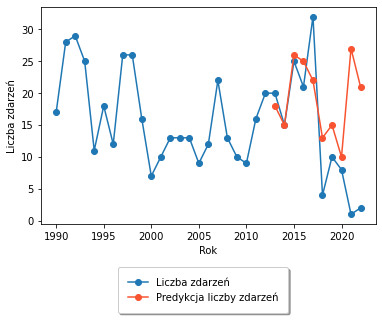

In [271]:
nhpp_pred = nhpp(power_law_int_fun,result_power_law.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred_power_law = pd.Series(merged_table['n'])

plt.plot(n, linestyle= '-',marker='o')
plt.plot(n_pred_power_law, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
plt.figlegend(['Liczba zdarzeń','Predykcja liczby zdarzeń'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\power_law_number.pdf",bbox_inches='tight')
plt.show()

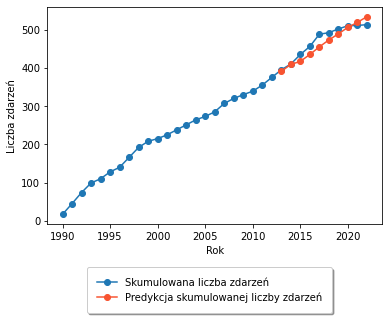

In [270]:
n_pred_power_law_cum = n_pred_power_law.cumsum()

plt.plot(N, linestyle= '-',marker='o')
plt.plot(N[2012]+n_pred_power_law_cum, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
plt.figlegend(['Skumulowana liczba zdarzeń','Predykcja skumulowanej liczby zdarzeń'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\power_law_cum_number.pdf",bbox_inches='tight')
plt.show()

In [269]:
#Wyniki

print(pd.DataFrame
({
    'funkcja':['Sinusoidalna funkcja straty','Power Law'],
    'parametry':[result_sin.x.round(2),result_power_law.x.round(2)],
    'MSE':[round(np.mean(MSE_sin),2),round(np.mean(MSE_sin),2)],
    'MAE':[round(np.mean(MAE_power_law),2),round(np.mean(MAE_power_law),2)]                                            
}))

                       funkcja           parametry     MSE   MAE
0  Sinusoidalna funkcja straty  [17.29, 2.41, 0.0]  129.18  9.66
1                    Power Law        [17.29, 1.0]  129.18  9.66


### Symulacja wartości odszkodowań

Dane zaobserwowane

In [206]:
loss_full = pd.DataFrame({"n":pd.Series(data_wo.groupby('Year').count()['Dis No']), "Damages":pd.Series(data_wo.groupby('Year').sum()["Insured Damages, Adjusted (\'000 US$)"])})
cum_loss_full = loss_full.cumsum()

In [207]:
loss_train= pd.DataFrame({"n":pd.Series(train.groupby('Year').count()['Dis No']), "Damages":pd.Series(train.groupby('Year').sum()["Insured Damages, Adjusted (\'000 US$)"])})
cum_loss_train = loss_train.cumsum()

In [208]:
loss_test= pd.DataFrame({"n":pd.Series(test.groupby('Year').count()['Dis No']), "Damages":pd.Series(test.groupby('Year').sum()["Insured Damages, Adjusted (\'000 US$)"])})
cum_loss_test = loss_test.cumsum()

Rozkład wykładniczy

In [209]:
#Sinusoidalna funkcja intensywności

loss_sin_exp = pd.DataFrame({"n":n_pred_sin, "Damages":[np.sum(stats.expon.rvs(scale=1/lambda_hat,loc=0,size=np.sum(n_pred_sin[i]))) for i in range(2013,2023)]})
cum_loss_sin_exp = loss_sin_exp.cumsum()

In [210]:
#Funkcja intensywności typu Power Law

loss_power_law_exp = pd.DataFrame({"n":n_pred_power_law, "Damages":[np.sum(stats.expon.rvs(scale=1/lambda_hat,loc=0,size=np.sum(int(n_pred_power_law[i])))) for i in range(2013,2023)]})
cum_loss_power_law_exp = loss_power_law_exp.cumsum()

Rozkład lognormalny

In [212]:
#Sinusoidalna funkcja intensywności

loss_sin_ln = pd.DataFrame({"n":n_pred_sin, "Damages":[np.sum(stats.lognorm.rvs(s=np.sqrt(sigma_sq_hat),scale=np.exp(mu_hat),size=np.sum(int(n_pred_sin[i])))) for i in range(2013,2023)]})
cum_loss_sin_ln = loss_sin_ln.cumsum()

In [213]:
#Funkcja intensywności typu Power Law

loss_power_law_ln = pd.DataFrame({"n":n_pred_power_law, "Damages":[np.sum(stats.lognorm.rvs(s=np.sqrt(sigma_sq_hat),scale=np.exp(mu_hat),size=np.sum(int(n_pred_power_law[i])))) for i in range(2013,2023)]})
cum_loss_power_law_ln = loss_power_law_ln.cumsum()

Rozkład gamma

In [214]:
#Sinusoidalna funkcja intensywności

loss_sin_gamma = pd.DataFrame({"n":n_pred_sin, "Damages":[np.sum(stats.gamma.rvs(a=gamma_alfa,scale=1/gamma_beta,size=np.sum(int(n_pred_sin[i])))) for i in range(2013,2023)]})
cum_loss_sin_gamma = loss_sin_gamma.cumsum()

In [215]:
#Funkcja intensywności typu Power Law

loss_power_law_gamma = pd.DataFrame({"n":n_pred_power_law, "Damages":[np.sum(stats.gamma.rvs(a=gamma_alfa,scale=1/gamma_beta,size=np.sum(int(n_pred_power_law[i])))) for i in range(2013,2023)]})
cum_loss_power_law_gamma = loss_power_law_gamma.cumsum()

Rozkład Weibulla

In [218]:
#Sinusoidalna funkcja intensywności

loss_sin_weibull = pd.DataFrame({"n":n_pred_sin, "Damages":[np.sum(stats.weibull_min.rvs(c=weibull_k,scale=weibull_lambda,size=np.sum(int(n_pred_sin[i])))) for i in range(2013,2023)]})
cum_loss_sin_weibull = loss_sin_weibull.cumsum()

In [219]:
#Funkcja intensywności typu Power Law

loss_power_law_weibull = pd.DataFrame({"n":n_pred_power_law, "Damages":[np.sum(stats.weibull_min.rvs(c=weibull_k,scale=weibull_lambda,size=np.sum(int(n_pred_power_law[i])))) for i in range(2013,2023)]})
cum_loss_power_law_weibull = loss_power_law_weibull.cumsum()

Rozkad Burra

In [220]:
#Sinusoidalna funkcja intensywności

loss_sin_burr = pd.DataFrame({"n":n_pred_sin, "Damages":[np.sum(stats.burr12.rvs(c=burr_c,d=burr_k,size=np.sum(int(n_pred_sin[i])))) for i in range(2013,2023)]})
cum_loss_sin_burr = loss_sin_burr.cumsum()

In [221]:
#Funkcja intensywności typu Power Law

loss_power_law_burr = pd.DataFrame({"n":n_pred_power_law, "Damages":[np.sum(stats.burr12.rvs(c=burr_c,d=burr_k,size=np.sum(int(n_pred_power_law[i])))) for i in range(2013,2023)]})
cum_loss_power_law_burr = loss_power_law_burr.cumsum()

### Symulacja strat

Rozkład wykładniczy

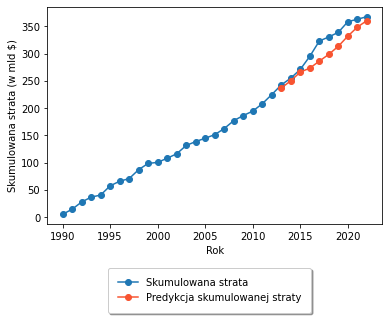

In [223]:
#Sinusoidalna funkcja intensywności

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_exp["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_exp_sin.pdf",bbox_inches='tight')
plt.show()

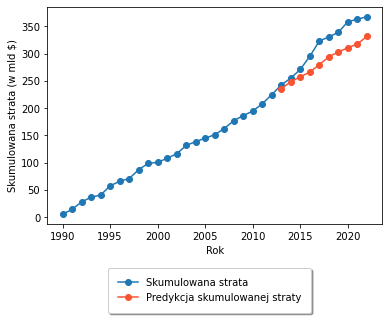

In [224]:
#Funkcja intensywności typu Power Law

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_power_law_exp["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_exp_power_law.pdf",bbox_inches='tight')
plt.show()

In [226]:
#Wyniki

print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy'],
    'funkcja':['Sinusoidalna funkcja straty','Power Law'],
    'MSE':["{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_sin_exp["Damages"])),"{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_power_law_exp["Damages"]))],
    'MAE':["{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_sin_exp["Damages"])),"{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_power_law_exp["Damages"]))]                                            
}))

       rozkład                      funkcja           MSE           MAE
0  Wykładniczy  Sinusoidalna funkcja straty  4.538527e+14  1.795563e+07
1  Wykładniczy                    Power Law  1.126392e+15  3.011665e+07


Rozkład lognormalny

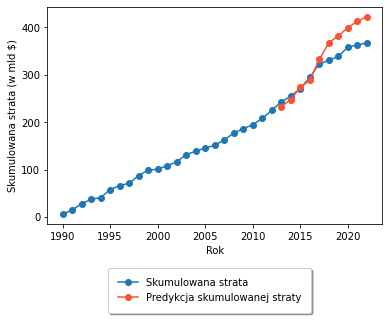

In [227]:
#Sinusoidalna funkcja intensywności

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_ln["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_ln_sin.pdf",bbox_inches='tight')
plt.show()

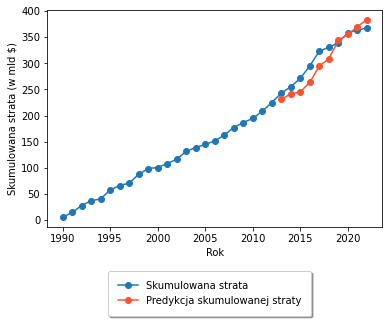

In [228]:
#Funkcja intensywności typu Power Law

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_power_law_ln["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_ln_power_law.pdf",bbox_inches='tight')
plt.show()

In [229]:
#Wyniki

print(pd.DataFrame
({
    'rozkład':['Lognormalny','Lognormalny'],
    'funkcja':['Sinusoidalna funkcja straty','Power Law'],
    'MSE':["{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_sin_ln["Damages"])),"{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_power_law_ln["Damages"]))],
    'MAE':["{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_sin_ln["Damages"])),"{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_power_law_ln["Damages"]))]                                            
}))

       rozkład                      funkcja           MSE           MAE
0  Lognormalny  Sinusoidalna funkcja straty  1.080475e+15  2.625750e+07
1  Lognormalny                    Power Law  3.597378e+14  1.637807e+07


Rozkład gamma

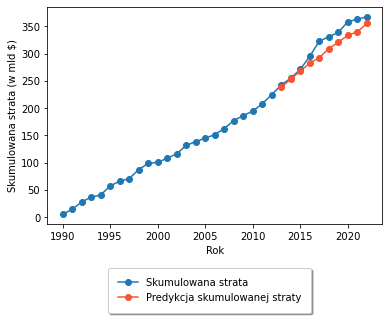

In [230]:
#Sinusoidalna funkcja intensywności

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_gamma["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_gamma_sin.pdf",bbox_inches='tight')
plt.show()

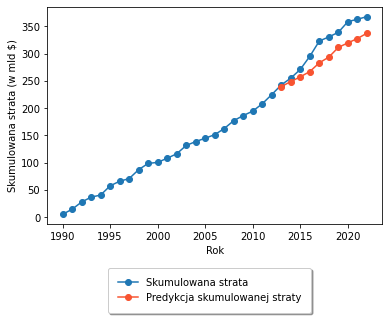

In [231]:
#Funkcja intensywności typu Power Law

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_power_law_gamma["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_gamma_power_law.pdf",bbox_inches='tight')
plt.show()

In [232]:
#Wyniki

print(pd.DataFrame
({
    'rozkład':['Gamma','Gamma'],
    'funkcja':['Sinusoidalna funkcja straty','Power Law'],
    'MSE':["{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_sin_gamma["Damages"])),"{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_power_law_gamma["Damages"]))],
    'MAE':["{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_sin_gamma["Damages"])),"{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_power_law_gamma["Damages"]))]                                            
}))

  rozkład                      funkcja           MSE           MAE
0   Gamma  Sinusoidalna funkcja straty  3.214450e+14  1.519815e+07
1   Gamma                    Power Law  8.438893e+14  2.603561e+07


Rozkład Weibulla

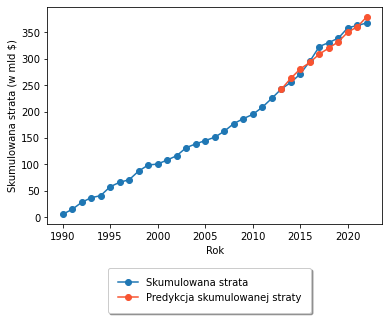

In [233]:
#Sinusoidalna funkcja intensywności

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_weibull["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_weibull_sin.pdf",bbox_inches='tight')
plt.show()

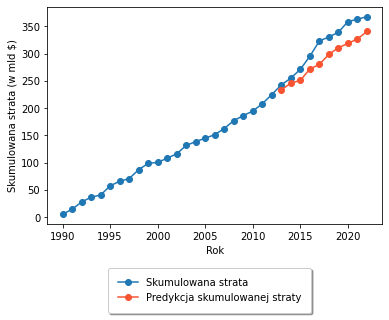

In [234]:
#Funkcja intensywności typu Power Law

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_power_law_weibull["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_weibull_power_law.pdf",bbox_inches='tight')
plt.show()

In [235]:
#Wyniki

print(pd.DataFrame
({
    'rozkład':['Weibull','Weibull'],
    'funkcja':['Sinusoidalna funkcja straty','Power Law'],
    'MSE':["{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_sin_weibull["Damages"])),"{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_power_law_weibull["Damages"]))],
    'MAE':["{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_sin_weibull["Damages"])),"{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_power_law_weibull["Damages"]))]                                            
}))

   rozkład                      funkcja           MSE           MAE
0  Weibull  Sinusoidalna funkcja straty  7.332710e+13  7.422940e+06
1  Weibull                    Power Law  8.432360e+14  2.685229e+07


Rozkład Burra

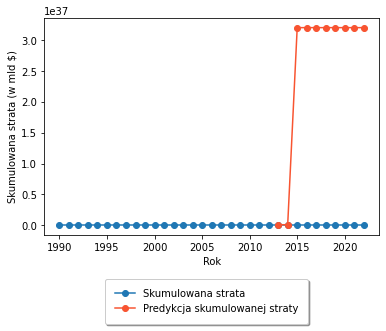

In [236]:
#Sinusoidalna funkcja intensywności

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_burr["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_burr_sin.pdf",bbox_inches='tight')
plt.show()

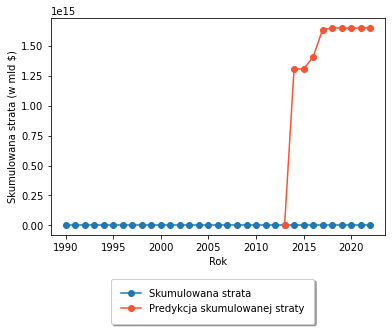

In [237]:
#Funkcja intensywności typu Power Law

plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_power_law_burr["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_burr_power_law.pdf",bbox_inches='tight')
plt.show()

In [238]:
# Wyniki

print(pd.DataFrame
({
    'rozkład':['Burr','Burr'],
    'funkcja':['Sinusoidalna funkcja straty','Power Law'],
    'MSE':["{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_sin_burr["Damages"])),"{:e}".format(MSE(cum_loss_test["Damages"],cum_loss_power_law_burr["Damages"]))],
    'MAE':["{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_sin_burr["Damages"])),"{:e}".format(MAE(cum_loss_test["Damages"],cum_loss_power_law_burr["Damages"]))]                                            
}))

  rozkład                      funkcja           MSE           MAE
0    Burr  Sinusoidalna funkcja straty  8.213039e+86  2.565181e+43
1    Burr                    Power Law  2.167982e+42  1.390540e+21


### Proces ryzyka

In [239]:
def risk_process(u, theta, mu, X, n, lambda_func, lambda_func_params, t_max):
    """
    Funkcja generuje niejednorodny proces Poissona metodą przerzerzedzania.

    Argumenty:
        u: float
            Kapitał początkowy
        theta: float
            Narzut
        mu: float
            Wartość oczekiwana X
        X: numpy.ndarray
            Wartości odszkodowań
        N: numpy.ndaray
            Liczba roszczeń
        lambda_func: funkcja
            Funkcja intensywności
        lambda_func_params: tab
            Tablica zawierająca parametry funkcji intensywności
        t_max: float
            Maksymalny czas symulacji
    Zwraca:
        numpy.ndarray
            Tablica procesu ryzyka
    """
    I = integrate.quad(lambda x: lambda_func(x,lambda_func_params)[0],0, t_max)[0]
    C=(1+theta)*mu*I
    loss = pd.DataFrame({"n":n, "Damages":X})
    cum_loss = loss.cumsum()

    R = u + C - cum_loss["Damages"]
    return R

In [240]:
def ruin_prob(u, theta, mu, lambda_func, lambda_func_params, loss_distribution, t_max, n):
    """
    Funkcja generuje niejednorodny proces Poissona metodą przerzerzedzania.

    Argumenty:
        u: float
            Kapitał początkowy
        theta: float
            Narzut
        mu: float
            Wartość oczekiwana X
        lambda_func: funkcja
            Funkcja intensywności
        loss_distribution: string
            Rozkład strat
        t_max: float
            Maksymalny czas symulacji
        n: int
            Liczba symulacji
    Zwraca:
        numpy.ndarray
            Tablica procesu ryzyka
    """
    negative = 0

    for i in range(n):
        if lambda_func == sin_int_fun:
            n_pred =np.unique(np.ceil(nhpp(sin_int_fun,result_sin.x,t_max)[1]), return_counts=True)[1]
        elif lambda_func == power_law_int_fun:
            n_pred =np.unique(np.ceil(nhpp(power_law_int_fun,result_power_law.x,t_max)[1]), return_counts=True)[1]
        elif lambda_func == musa_okumoto_int_fun:
            n_pred =np.unique(np.ceil(nhpp(musa_okumoto_int_fun,result_musa_okumoto.x,t_max)[1]), return_counts=True)[1]
        if loss_distribution == "expon":
            X = [np.sum(stats.expon.rvs(scale=1/lambda_hat,loc=0,size=np.sum(i))) for i in n_pred]
        elif loss_distribution == "lognormal":
            X = [np.sum(stats.lognorm.rvs(s=np.sqrt(sigma_sq_hat),scale=np.exp(mu_hat),size=np.sum(i))) for i in n_pred]
        elif loss_distribution == "gamma":
            X = [np.sum(stats.gamma.rvs(a=gamma_alfa,scale=1/gamma_beta,size=np.sum(i))) for i in n_pred]
        elif loss_distribution == "weibull":
            X = [np.sum(stats.weibull_min.rvs(c=weibull_k,scale=weibull_lambda,size=np.sum(i))) for i in n_pred]
        elif loss_distribution == "burr":
            X = [np.sum(stats.burr12.rvs(c=burr_c,d=burr_k,size=np.sum(i))) for i in n_pred]
        R = risk_process(u, theta, mu, X, n_pred, lambda_func, lambda_func_params, t_max)
        if sum(R<0):
            negative += 1
    return(negative/n)

Sinusoidalna funkcja intensywności

In [241]:
rp_5_expon_sin = ruin_prob(1e7,0.3,1/lambda_hat,sin_int_fun,result_sin.x,"expon",5,10000)
rp_10_expon_sin = ruin_prob(1e7,0.3,1/lambda_hat,sin_int_fun,result_sin.x,"expon",10,10000)

In [243]:
rp_5_lognormal_sin = ruin_prob(1e7,0.3,np.exp(mu_hat+sigma_sq_hat/2),sin_int_fun,result_sin.x,"lognormal",5,10000)
rp_10_lognormal_sin = ruin_prob(1e7,0.3,np.exp(mu_hat+sigma_sq_hat/2),sin_int_fun,result_sin.x,"lognormal",10,10000)

In [244]:
rp_5_gamma_sin = ruin_prob(1e7,0.3,gamma_alfa/gamma_beta,sin_int_fun,result_sin.x,"gamma",5,10000)
rp_10_gamma_sin = ruin_prob(1e7,0.3,gamma_alfa/gamma_beta,sin_int_fun,result_sin.x,"gamma",10,10000)

In [245]:
rp_5_weibull_sin = ruin_prob(1e7,0.3,weibull_lambda*gamma(1+1/weibull_k),sin_int_fun,result_sin.x,"weibull",5,10000)
rp_10_weibull_sin = ruin_prob(1e7,0.3,weibull_lambda*gamma(1+1/weibull_k),sin_int_fun,result_sin.x,"weibull",10,10000)

In [246]:
rp_5_burr_sin = ruin_prob(1e7,0.3,burr_k*beta(burr_k-1/burr_c,1+1/burr_c),sin_int_fun,result_sin.x,"burr",5,10000)
rp_10_burr_sin = ruin_prob(1e7,0.3,burr_k*beta(burr_k-1/burr_c,1+1/burr_c),sin_int_fun,result_sin.x,"burr",10,10000)

Funkcja intensywności typu Power Law

In [247]:
rp_5_expon_power_law = ruin_prob(1e7,0.3,1/lambda_hat,power_law_int_fun,result_power_law.x,"expon",5,10000)
rp_10_expon_power_law = ruin_prob(1e7,0.3,1/lambda_hat,power_law_int_fun,result_power_law.x,"expon",10,10000)

In [248]:
rp_5_lognormal_power_law = ruin_prob(1e7,0.3,np.exp(mu_hat+sigma_sq_hat/2),power_law_int_fun,result_power_law.x,"lognormal",5,10000)
rp_10_lognormal_power_law = ruin_prob(1e7,0.3,np.exp(mu_hat+sigma_sq_hat/2),power_law_int_fun,result_power_law.x,"lognormal",10,10000)

In [249]:
rp_5_gamma_power_law = ruin_prob(1e7,0.3,gamma_alfa/gamma_beta,power_law_int_fun,result_power_law.x,"gamma",5,10000)
rp_10_gamma_power_law = ruin_prob(1e7,0.3,gamma_alfa/gamma_beta,power_law_int_fun,result_power_law.x,"gamma",10,10000)

In [250]:
rp_5_weibull_power_law = ruin_prob(1e7,0.3,weibull_lambda*gamma(1+1/weibull_k),power_law_int_fun,result_power_law.x,"weibull",5,10000)
rp_10_weibull_power_law = ruin_prob(1e7,0.3,weibull_lambda*gamma(1+1/weibull_k),power_law_int_fun,result_power_law.x,"weibull",10,10000)

In [251]:
rp_5_burr_power_law = ruin_prob(1e7,0.3,burr_k*beta(burr_k-1/burr_c,1+1/burr_c),power_law_int_fun,result_power_law.x,"burr",5,10000)
rp_10_burr_power_law = ruin_prob(1e7,0.3,burr_k*beta(burr_k-1/burr_c,1+1/burr_c),power_law_int_fun,result_power_law.x,"burr",10,10000)

In [252]:
print(pd.DataFrame
({
    'rozkład':['Wykładniczy','Wykładniczy','Lognormalny','Lognormalny',"Gamma","Gamma","Weibulla","Weibulla","Burra","Burra"],
    'funkcja':['Sinusoidalna funkcja straty','Power Law','Sinusoidalna funkcja straty','Power Law','Sinusoidalna funkcja straty','Power Law','Sinusoidalna funkcja straty','Power Law','Sinusoidalna funkcja straty','Power Law'],
    '5 lat':[rp_5_expon_sin,rp_5_expon_power_law,rp_5_lognormal_sin,rp_5_lognormal_power_law,rp_5_gamma_sin,rp_5_gamma_power_law,rp_5_weibull_sin,rp_5_weibull_power_law,rp_5_burr_sin,rp_5_burr_power_law],
    '10 lat':[rp_10_expon_sin,rp_10_expon_power_law,rp_10_lognormal_sin,rp_10_lognormal_power_law,rp_10_gamma_sin,rp_10_gamma_power_law,rp_10_weibull_sin,rp_10_weibull_power_law,rp_10_burr_sin,rp_10_burr_power_law]
}))

       rozkład                      funkcja   5 lat  10 lat
0  Wykładniczy  Sinusoidalna funkcja straty  0.0036  0.0005
1  Wykładniczy                    Power Law  0.0023  0.0002
2  Lognormalny  Sinusoidalna funkcja straty  0.0969  0.0686
3  Lognormalny                    Power Law  0.0902  0.0716
4        Gamma  Sinusoidalna funkcja straty  0.0057  0.0018
5        Gamma                    Power Law  0.0058  0.0020
6     Weibulla  Sinusoidalna funkcja straty  0.0103  0.0026
7     Weibulla                    Power Law  0.0092  0.0032
8        Burra  Sinusoidalna funkcja straty  1.0000  1.0000
9        Burra                    Power Law  1.0000  1.0000


## Bootstrap

### Klasyczny bootstrap

In [673]:
def bootstrap(data,S , B = 100):
    """
    Argumenty:
        data: pd.Series
            Ciąg start
        B: float
            Liczba próbek bootstrapowych
        S: fun
            Statystka
    Zwraca:
        
            
    """
    X= []
    for i in range(B):
        X.append(S(pd.Series(data).sample(len(data),replace=True)))
    std = np.sqrt(np.sum(np.square(X-np.mean(X)))/(B-1))
    print("S: ",round(S(X),2),"std(S): ", round(std,2), "CI: ",[S(X)-stats.t.ppf(1-2.5/100,len(X)-1)*std/np.sqrt(len(X)),S(X)-stats.t.ppf(2.5/100,len(X)-1)*std/np.sqrt(len(X))])
    return(S(X),std,[S(X)-stats.t.ppf(1-2.5/100,len(X)-1)*std/np.sqrt(len(X)),S(X)-stats.t.ppf(2.5/100,len(X)-1)*std/np.sqrt(len(X))])

In [701]:
def bootstrap(data,S ,alpha, B = 100):
    """
    Argumenty:
        data: pd.Series
            Ciąg start
        B: float
            Liczba próbek bootstrapowych
        S: fun
            Statystka
        alpha: float
            Poziom istotności
    Zwraca:
        
            
    """
    X= []
    for i in range(B):
        X.append(S(pd.Series(data).sample(len(data),replace=True)))
    std = np.sqrt(np.sum(np.square(X-np.mean(X)))/(B-1))
    print("S: ",round(S(X),2),"std(S): ", round(std,2), "CI: ",[round(np.percentile(X,alpha/2),2),round(np.percentile(X,100-alpha/2),2)])
    return(S(X),std,[np.percentile(X,alpha/2),np.percentile(X,100-alpha/2)],X)

In [702]:
b = bootstrap(loss_train['Damages'],np.mean,5,100)

S:  9904558.46 std(S):  868637.57 CI:  [8320950.016304348, 11273473.130434781]


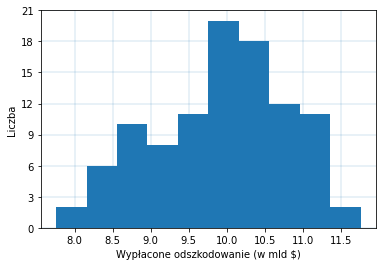

In [724]:
plt.hist(np.array(b[3])/1e6)
plt.xlabel("Wypłacone odszkodowanie (w mld $)")
plt.ylabel("Liczba")
plt.grid(color='C0', linestyle='-', linewidth=0.2)
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_xlim(left=0)
#ax.set_yticks(np.linspace(1,11,num=11))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\bootstrap_hist.pdf")
plt.show()

In [618]:
stats.bootstrap((loss_train['Damages'],),np.mean,confidence_level=0.95)

BootstrapResult(confidence_interval=ConfidenceInterval(low=8091255.947095301, high=11550465.057648512), standard_error=884141.2447429087)

In [698]:
bootstrap = pd.DataFrame({"n":pd.Series(test.groupby('Year').count()['Dis No']), "Mean":b[0], "LB": b[2][0], "UB": b[2][1]})
cum_bootstrap = bootstrap.cumsum()

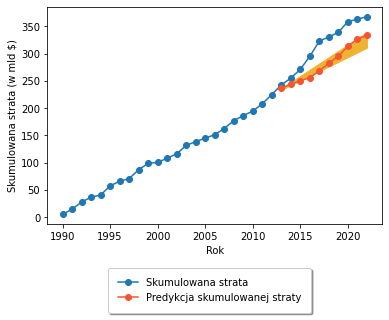

In [725]:
#Sinusoidalna funkcja intensywności
plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_exp["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.fill_between(cum_loss_sin_exp.index,(cum_bootstrap["LB"]+cum_loss_full["Damages"][2012])/1e6,(cum_bootstrap["UB"]+cum_loss_full["Damages"][2012])/1e6,color="#efb332")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_exp_sin_bootstrap.pdf",bbox_inches='tight')
plt.show()

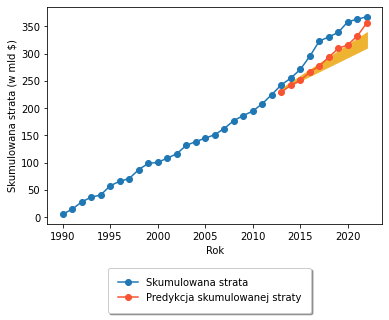

In [726]:
#Sinusoidalna funkcja intensywności
plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_ln["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.fill_between(cum_loss_sin_ln.index,(cum_bootstrap["LB"]+cum_loss_full["Damages"][2012])/1e6,(cum_bootstrap["UB"]+cum_loss_full["Damages"][2012])/1e6,color="#efb332")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_ln_sin_bootstrap.pdf",bbox_inches='tight')
plt.show()

### Bootknife

In [728]:
def bootknife(data,S ,alpha, B = 100):
    """
    Argumenty:
        data: pd.Series
            Ciąg start
        B: float
            Liczba próbek bootstrapowych
        S: fun
            Statystka
        alpha: float
            Poziom istotności
    Zwraca:
        
            
    """
    X= []
    for i in range(B):
        obs_to_delete = random.choice(pd.Series(data).index)
        data_r = data.drop(obs_to_delete)
        X.append(S(pd.Series(data_r).sample(len(data),replace=True)))
    std = np.sqrt(np.sum(np.square(X-np.mean(X)))/(B-1))
    print("S: ",round(S(X),2),"std(S): ", round(std,2), "CI: ",[round(np.percentile(X,alpha/2),2),round(np.percentile(X,100-alpha/2),2)])
    return(S(X),std,[np.percentile(X,alpha/2),np.percentile(X,100-alpha/2)],X)

In [732]:
b2 = bootknife(loss_train['Damages'],np.mean,5,100)

S:  9867131.01 std(S):  973764.36 CI:  [8148087.64, 11847820.25]


In [734]:
bootknife = pd.DataFrame({"n":pd.Series(test.groupby('Year').count()['Dis No']), "Mean":b[0], "LB": b[2][0], "UB": b[2][1]})
cum_bootknife = bootknife.cumsum()

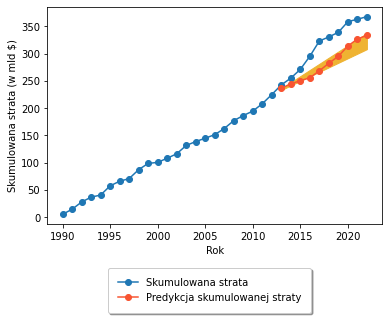

In [735]:
#Sinusoidalna funkcja intensywności
plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_exp["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.fill_between(cum_loss_sin_exp.index,(cum_bootknife["LB"]+cum_loss_full["Damages"][2012])/1e6,(cum_bootknife["UB"]+cum_loss_full["Damages"][2012])/1e6,color="#efb332")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_exp_sin_bootknife.pdf",bbox_inches='tight')
plt.show()

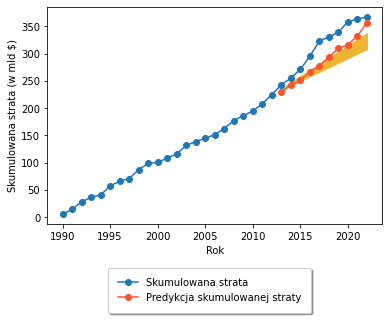

In [736]:
#Sinusoidalna funkcja intensywności
plt.plot(cum_loss_full["Damages"]/1e6, linestyle= '-',marker='o')
plt.plot((cum_loss_sin_ln["Damages"]+cum_loss_full["Damages"][2012])/1e6, linestyle= '-',marker='o',color="#f85431")
plt.fill_between(cum_loss_sin_ln.index,(cum_bootknife["LB"]+cum_loss_full["Damages"][2012])/1e6,(cum_bootknife["UB"]+cum_loss_full["Damages"][2012])/1e6,color="#efb332")
plt.xlabel("Rok")
plt.ylabel("Skumulowana strata (w mld $)")
plt.figlegend(['Skumulowana strata','Predykcja skumulowanej straty'],loc='lower center', fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(0.5, -0.2))
plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\cum_loss_ln_sin_bootknife.pdf",bbox_inches='tight')
plt.show()